#HOMA Test

##Get data

In [ ]:
import pandas as pd
from urllib.parse import quote_plus
import sqlalchemy
import matplotlib.pyplot as plt

redshift_host = 'homa.498688325066.eu-west-3.redshift-serverless.amazonaws.com'
redshift_port = '5439'
db_username = 'external'
db_password ='zU4ZfRmobHLB!xYGs8@A'
db_name = 'dev'
connection_str = f'postgresql+psycopg2://{db_username}:{quote_plus(db_password)}'\
f'@{redshift_host}:{redshift_port}/{db_name}'
connection = sqlalchemy.create_engine(connection_str)
def run_redshift_query(query):
  return pd.read_sql(sql=sqlalchemy.text(query), con = connection)
run_redshift_query('select * from public.raw_rv_events limit 5')

,user_id,rv_name,rv_event,event_client_ts
0,001f5a26-9724-4ab7-8543-5ad888028ac2,MultiplyX3,Closed,2022-05-28 14:31:56
1,0024db27-f15c-4a62-a91b-d43f2a6f8740,FullHeroStart,Closed,2022-05-29 19:28:41
2,003a7d0d-b603-46d6-b7aa-26ff11890fad,FullHeroStart,Closed,2022-05-30 04:17:26
3,003a7d0d-b603-46d6-b7aa-26ff11890fad,FullHeroStart,Closed,2022-05-31 14:22:12
4,00452ed8-8d8b-4c6a-a850-bd359fb8d3b8,FullHeroStart,Closed,2022-05-27 22:18:16


##Question1

Provide a visualization of the most suggested RVs as
well as the Take Rate (Taken / Suggested)


In [ ]:
# overview of rv count
rv_event_num = run_redshift_query('select rv_name, rv_event, count(rv_event) as rv_event_num from public.raw_rv_events group by rv_name, rv_event order by rv_name')
# events count dataframe pivot
rv_event_num = rv_event_num.set_index(['rv_name','rv_event'])['rv_event_num'].unstack()
rv_event_num.columns.name = None
rv_event_num = rv_event_num.reset_index()
reorder = ['rv_name','Suggested','Opened','Taken','Closed','Failed']
rv_event_num = rv_event_num[reorder]
rv_event_num

,rv_name,Suggested,Opened,Taken,Closed,Failed
0,ClaimHero,1615,106118,74946,36980,58304
1,ClaimNewHero,1193686,120134,95686,29444,33989
2,FullHeroStart,6521008,467294,322143,170104,81130
3,GetCurrency,6681673,116651,82721,38830,32282
4,MultiplyDynamic,1007241,57236,38541,19906,19544
5,MultiplyX3,1221525,62148,43131,24229,15307
6,PlayBonusLevel,1682197,135742,109832,30047,38653
7,Revive,825980,70806,35485,39717,18133


In [ ]:
# overview of rv count (remove duplicates)
rv_event_num_no_dup = run_redshift_query('select rv_name, rv_event, count(rv_event) as rv_event_num from (select distinct * from public.raw_rv_events) group by rv_name, rv_event order by rv_name')
# no duplicate events count dataframe pivot
rv_event_num_no_dup = rv_event_num_no_dup.set_index(['rv_name','rv_event'])['rv_event_num'].unstack()
rv_event_num_no_dup.columns.name = None
rv_event_num_no_dup = rv_event_num_no_dup.reset_index()
reorder = ['rv_name','Suggested','Opened','Taken','Closed','Failed']
rv_event_num_no_dup = rv_event_num_no_dup[reorder]
rv_event_num_no_dup['take_rate'] = rv_event_num_no_dup['Taken']/rv_event_num_no_dup['Suggested']
rv_event_num_no_dup

,rv_name,Suggested,Opened,Taken,Closed,Failed,take_rate
0,ClaimHero,663,105221,74471,36801,10203,112.324284
1,ClaimNewHero,1138448,119815,95656,29335,9623,0.084023
2,FullHeroStart,5640273,454143,310625,169357,32393,0.055073
3,GetCurrency,5734408,116293,82499,38769,10152,0.014387
4,MultiplyDynamic,905541,56994,38486,19872,10630,0.042501
5,MultiplyX3,1098401,61899,42983,24177,6421,0.039132
6,PlayBonusLevel,778567,134944,109305,29968,11496,0.140393
7,Revive,691566,70136,35217,39403,6568,0.050924


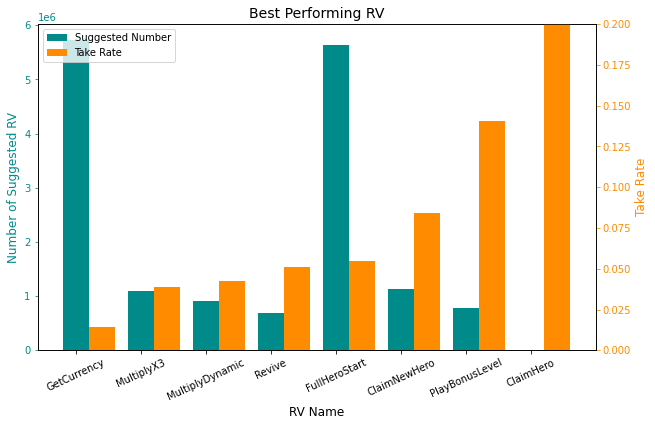

In [ ]:
# plot take rate without duplicates

data_sort = rv_event_num_no_dup.sort_values('take_rate')
fig,ax1 = plt.subplots(figsize=(10,6))
# bar width
width = 0.4

# bar interval
x1_list = []
x2_list = []
for i in range(len(data_sort)):
    x1_list.append(i)
    x2_list.append(i + width)

# plot bar1
b1 = ax1.bar(x1_list, data_sort['Suggested'],width=width,label="Suggested Number",color = "darkcyan",tick_label = data_sort['rv_name'])

# plot bar2
ax2 = ax1.twinx()
b2 = ax2.bar(x2_list, data_sort['take_rate'],width=width,label="Take Rate",color = 'darkorange')

# set labels
ax1.set_title('Best Performing RV',fontsize = 14)
ax1.set_xlabel('RV Name',fontsize=12)
ax1.set_ylabel('Number of Suggested RV',fontsize=12)
ax2.set_ylabel('Take Rate',fontsize=12)
ax2.set_ylim(0,0.2)

# xlabels rotation
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 25)

# set ylabels color
ax1.yaxis.label.set_color(b1[0].get_facecolor())
ax2.yaxis.label.set_color(b2[0].get_facecolor())

# set tick color
ax1.tick_params(axis = 'y', colors = b1[0].get_facecolor())
ax2.tick_params(axis = 'y', colors = b2[0].get_facecolor())

plt.legend(handles = [b1,b2])

plt.show()

## Question 2
Why the number of suggested events for the PlayBonusLevel RV seems to be abnormally high?


<ipython-input-65-237eee24c9cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_event_com['Suggested_no_dup'] = rv_event_num_no_dup['Suggested']
<ipython-input-65-237eee24c9cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_event_com['dup_ratio'] = (rv_event_num['Suggested'] - rv_event_num_no_dup['Suggested'])/rv_event_num['Suggested']


<function matplotlib.pyplot.show(close=None, block=None)>

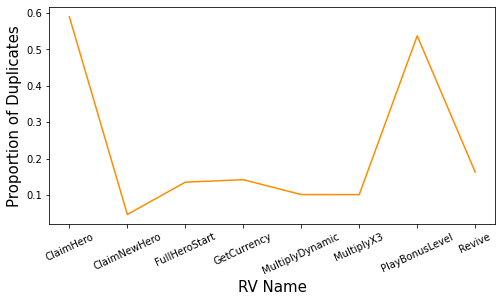

In [ ]:
# plot proportion of duplicates of all suggested RVs
rv_event_com = rv_event_num[['rv_name','Suggested']]
rv_event_com['Suggested_no_dup'] = rv_event_num_no_dup['Suggested']
rv_event_com['dup_ratio'] = (rv_event_num['Suggested'] - rv_event_num_no_dup['Suggested'])/rv_event_num['Suggested']

x = rv_event_com['rv_name']
y = rv_event_com['dup_ratio']

fig = plt.figure(figsize=(8,4))
plt.plot(x,y,color = "darkorange")
plt.xticks(rotation=25)
plt.xlabel("RV Name", fontsize = 15)
plt.ylabel("Proportion of Duplicates", fontsize = 15)
plt.show

### 1.Suggested playbounslevel abnoramlly high on certian days.

In [ ]:
PlayBonusLevel_suggested_day = run_redshift_query("select CAST(event_client_ts as DATE),count(CAST(event_client_ts as DATE)) as suggested_num_day from public.raw_rv_events \
where raw_rv_events.rv_name = 'PlayBonusLevel' and raw_rv_events.rv_event = 'Suggested' group by CAST(event_client_ts as DATE) order by event_client_ts")
PlayBonusLevel_suggested_day_no_dup = run_redshift_query("select CAST(event_client_ts as DATE),count(CAST(event_client_ts as DATE)) as suggested_num_day from (select distinct * from public.raw_rv_events) \
where rv_name = 'PlayBonusLevel' and rv_event = 'Suggested' group by CAST(event_client_ts as DATE) order by event_client_ts")

<ipython-input-74-bc4b3284d255>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 25)


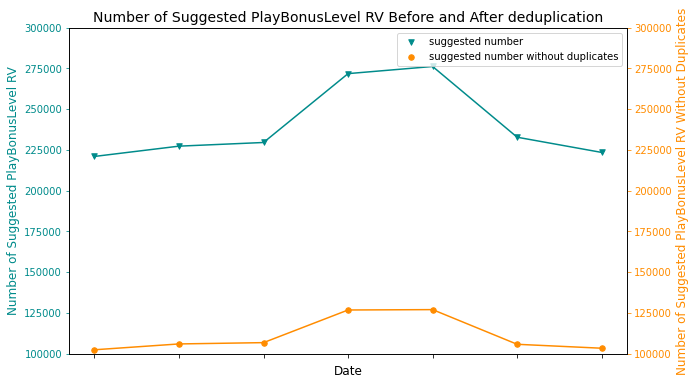

In [ ]:
# plot number of suggested PlayBonusLevel over time
fig, ax1 = plt.subplots(figsize=(10,6))

line1, = ax1.plot(PlayBonusLevel_suggested_day['event_client_ts'], PlayBonusLevel_suggested_day['suggested_num_day'],
                  color = 'darkcyan',linestyle = '-',label = 'suggested number')
p1 = ax1.scatter(PlayBonusLevel_suggested_day['event_client_ts'], PlayBonusLevel_suggested_day['suggested_num_day'],
                 color = 'darkcyan',marker = 'v',s = 30,label = 'suggested number')

ax2 = ax1.twinx()
line2, = ax2.plot(PlayBonusLevel_suggested_day_no_dup['event_client_ts'], PlayBonusLevel_suggested_day_no_dup['suggested_num_day'],
                  color = 'darkorange',linestyle = '-',label = 'suggested number without duplicates')
p2 = ax2.scatter(PlayBonusLevel_suggested_day_no_dup['event_client_ts'], PlayBonusLevel_suggested_day_no_dup['suggested_num_day'],
                 color = 'darkorange',marker = 'o',s = 30,label = 'suggested number without duplicates')


ax1.set_ylim([100000,300000])
ax2.set_ylim([100000,300000])

ax1.set_xlabel("Date",fontsize = 12)
ax1.set_ylabel("Number of Suggested PlayBonusLevel RV",fontsize = 12)
ax2.set_ylabel("Number of Suggested PlayBonusLevel RV Without Duplicates",fontsize = 12)
ax1.set_title("Number of Suggested PlayBonusLevel RV Before and After deduplication",fontsize = 14)

ax1.yaxis.label.set_color(line1.get_color())
ax2.yaxis.label.set_color(line2.get_color())

ax1.tick_params(axis = 'y', colors = line1.get_color())
ax2.tick_params(axis = 'y', colors = line2.get_color())

ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 25)
plt.legend(handles = [p1,p2])

plt.show()

### 2.Suggested playbounslevel abnoramlly high for certian users.

In [ ]:
# Check if PlayBonusLevel suggested duplicate happened to every player
import numpy as np

PlayBonusLevel_suggested_user = run_redshift_query("select user_id,count(user_id) as suggested_num from public.raw_rv_events \
where raw_rv_events.rv_name = 'PlayBonusLevel' and raw_rv_events.rv_event = 'Suggested' group by user_id order by suggested_num desc")
PlayBonusLevel_suggested_user_no_dup = run_redshift_query("select user_id,count(user_id) as suggested_num_no_dup from (select distinct * from public.raw_rv_events) \
where rv_name = 'PlayBonusLevel' and rv_event = 'Suggested' group by user_id")
com_user_num = pd.merge(PlayBonusLevel_suggested_user,PlayBonusLevel_suggested_user_no_dup)
com_user_num['com'] = np.where(com_user_num['suggested_num']==com_user_num['suggested_num_no_dup'],'same','different')
com_user_num.head(5)

,user_id,suggested_num,suggested_num_no_dup,com
0,a7814abe-fbf1-4f47-9548-6cfb5cc03829,7192,591,different
1,2ed52a2f-0339-4541-84ba-daa832c7162d,3000,250,different
2,c06cf152-1662-4d67-926f-6b7937de2d76,2180,376,different
3,5a6f442a-4f3b-46bd-8c6e-ccb3402442d3,978,197,different
4,b4e8e6f1-ec81-4d84-80cb-3c99255eb7b1,858,256,different


## Question 3
How is the Take Rate evolving depending on the number of times the RV has been suggested to a player ?


In [ ]:
# Calculate the change in take rate as the number of one suggested RV increases in one day
def cumsum_sugg(file, rv_name):
  # read one day file
  rv = pd.read_csv(file)
  # remove duplicates
  rv = rv.drop_duplicates()
  # keep only suggested and taken events
  rv = rv[(rv['rv_event'] == 'Suggested')| (rv['rv_event'] == 'Taken')]
  # choose one RV
  rv = rv[(rv['rv_name'] == rv_name)]

  # number of users who take at least one suggested RV in one day
  taken_user_id = set(rv[(rv['rv_event'] == 'Taken')]['user_id'])
  all_user_id = set(rv[(rv['rv_event'] == 'Suggested')]['user_id'])
  print("Number of users who receive",rv_name,"suggested RVs: ",len(all_user_id))
  print("Number of users who never take",rv_name,"suggested RVs: ",len(all_user_id)-len(taken_user_id))

  # accumulate number of suggested RV group by user_id
  # number of suggested RV can be used as index afterwards
  taken_user_df = rv.sort_values(by = ['user_id','event_client_ts'])
  taken_user_df['suggested'] = taken_user_df['rv_event'].map(lambda a: 1 if a == 'Suggested' else 0)
  taken_user_df['taken'] = taken_user_df['rv_event'].map(lambda a: 1 if a == 'Taken' else 0)
  taken_user_df['sug_cum'] = taken_user_df.groupby(['user_id'])['suggested'].cumsum()
  # delete duplicate records which have both suggested and taken events
  taken_user_df = taken_user_df.drop(taken_user_df[taken_user_df['rv_event'].shift(-1) == 'Taken'].index,axis = 0)
  return taken_user_df

def evolving_rate(taken_user_df):
  take_rate_df = pd.DataFrame()
  # calculate how many users recieve the suggested RV
  sug_num = taken_user_df.groupby(['sug_cum'])['suggested'].count()
  # calculate how many users take the corresponding suggested RV
  take_num = taken_user_df.groupby(['sug_cum'])['taken'].sum()
  take_rate_df['suggested_number'] = sug_num
  # take rate is number of taken divides number of suggested
  take_rate_df['take_rate'] = take_num/sug_num
  take_rate_df = take_rate_df.drop(0)
  return take_rate_df

In [ ]:
# Select which df to plot
# With the number of suggested RV increase, the number of users who recieve suggested decrease, which may result in fluctuation of take rate,
# thus only select records when suggested number > num
def plot_take_rate(df,num):
  df = df.drop(df[df['suggested_number']<num].index).reset_index()
  x = df['sug_cum']
  y = df['take_rate']

  fig = plt.figure(figsize=(8,4))
  plt.plot(x,y,color = "darkorange")
  plt.xticks(rotation=25)
  plt.xlabel("Suggested Frequency", fontsize = 15)
  plt.ylabel("Take Rate", fontsize = 15)
  plt.show

Number of users who receive FullHeroStart suggested RVs:  157657
Number of users who never take FullHeroStart suggested RVs:  126781


,suggested_number,take_rate
sug_cum,,
1,157593,0.028910
2,126255,0.043990
3,100131,0.050054
4,81215,0.045016
5,65838,0.048710
...,...,...
374,1,1.000000
375,1,1.000000
376,1,1.000000


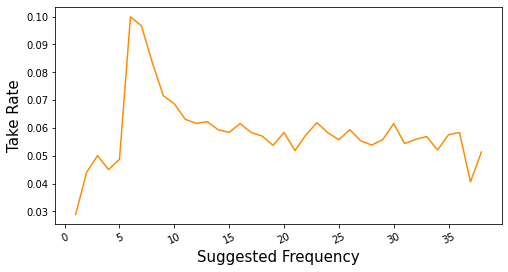

In [ ]:
# select which day and which RV to analyze
take_rate_df = evolving_rate(cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-29.csv.gz', 'FullHeroStart'))
plot_take_rate(take_rate_df,1000)
take_rate_df

Number of users who receive FullHeroStart suggested RVs:  129052
Number of users who never take FullHeroStart suggested RVs:  103743
Number of users who receive FullHeroStart suggested RVs:  133315
Number of users who never take FullHeroStart suggested RVs:  107457
Number of users who receive FullHeroStart suggested RVs:  135250
Number of users who never take FullHeroStart suggested RVs:  109408
Number of users who receive FullHeroStart suggested RVs:  156450
Number of users who never take FullHeroStart suggested RVs:  126057
Number of users who receive FullHeroStart suggested RVs:  157657
Number of users who never take FullHeroStart suggested RVs:  126781
Number of users who receive FullHeroStart suggested RVs:  133482
Number of users who never take FullHeroStart suggested RVs:  107810
Number of users who receive FullHeroStart suggested RVs:  129740
Number of users who never take FullHeroStart suggested RVs:  104473


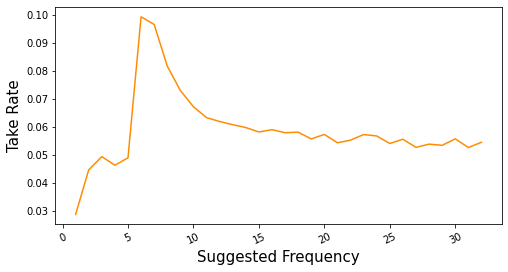

In [ ]:
# take rate of FullHeroStart evolving across 7 days
df25 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-25.csv.gz', 'FullHeroStart')
df26 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-26.csv.gz', 'FullHeroStart')
df27 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-27.csv.gz', 'FullHeroStart')
df28 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-28.csv.gz', 'FullHeroStart')
df29 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-29.csv.gz', 'FullHeroStart')
df30 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-30.csv.gz', 'FullHeroStart')
df31 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-31.csv.gz', 'FullHeroStart')
weeks_df = pd.concat([df25,df26,df27,df28,df29,df30,df31])
week_take_rate_df = evolving_rate(weeks_df)
plot_take_rate(week_take_rate_df,10000)

Number of users who receive PlayBonusLevel suggested RVs:  62136
Number of users who never take PlayBonusLevel suggested RVs:  50820
Number of users who receive PlayBonusLevel suggested RVs:  63942
Number of users who never take PlayBonusLevel suggested RVs:  52523
Number of users who receive PlayBonusLevel suggested RVs:  64713
Number of users who never take PlayBonusLevel suggested RVs:  52999
Number of users who receive PlayBonusLevel suggested RVs:  76017
Number of users who never take PlayBonusLevel suggested RVs:  61678
Number of users who receive PlayBonusLevel suggested RVs:  75662
Number of users who never take PlayBonusLevel suggested RVs:  61537
Number of users who receive PlayBonusLevel suggested RVs:  63771
Number of users who never take PlayBonusLevel suggested RVs:  52308
Number of users who receive PlayBonusLevel suggested RVs:  62393
Number of users who never take PlayBonusLevel suggested RVs:  51380


,suggested_number,take_rate
sug_cum,,
1,468418,0.144271
2,164827,0.137041
3,67126,0.135462
4,32346,0.123014
5,16692,0.123892
...,...,...
309,1,0.000000
310,1,0.000000
311,1,0.000000


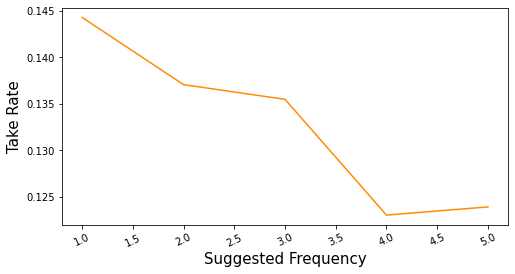

In [ ]:
# take rate of PlayBonusLevel evolving across 7 days
# the curve is more smoothe but still cannot decide which is the best number of suggested RVs
df25 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-25.csv.gz', 'PlayBonusLevel')
df26 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-26.csv.gz', 'PlayBonusLevel')
df27 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-27.csv.gz', 'PlayBonusLevel')
df28 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-28.csv.gz', 'PlayBonusLevel')
df29 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-29.csv.gz', 'PlayBonusLevel')
df30 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-30.csv.gz', 'PlayBonusLevel')
df31 = cumsum_sugg('https://hg-data-interview.s3.us-east-2.amazonaws.com/public/analytics-case-study/rv_events_data_2022-05-31.csv.gz', 'PlayBonusLevel')
weeks_df = pd.concat([df25,df26,df27,df28,df29,df30,df31])
week_take_rate_df = evolving_rate(weeks_df)
plot_take_rate(week_take_rate_df,10000)
week_take_rate_df